In [1]:
import pytest

In [2]:
from altaipony.utils import sigma_clip

In [3]:
from funcs.notebook import *
from altaipony.flarelc import FlareLightCurve
from altaipony.altai import find_iterative_median

import copy
from scipy.interpolate import UnivariateSpline
from scipy import optimize
from funcs.detrend import search_gaps_for_window_length, fit_spline, estimate_detrended_noise

import astropy.units as u

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [181]:
def custom_detrending(lc):
    # fit a spline to the general trends
    plt.figure(figsize=(16,8))
#     plt.xlim(20,21)
    plt.plot(lc.time, lc.flux+2500, c="c", label="original light curve")
    
    lc__, model = fit_spline(lc, spline_order=2)
    
    lc__.flux = lc__.detrended_flux
    
    plt.plot(lc__.time, model+2500, c="r", label="rough trends")
    plt.plot(lc__.time, lc__.detrended_flux+500, c="orange", label="rough trends removed")

    # removes strong and fast variability
    lcs = iteratively_remove_sines(lc__)
    
    # spline sometime does not capture the edges
#     dt = np.nanmin(np.diff(lcs.time))
#     roll = int(np.rint(1. / dt))
#     lcs.flux[:] = (lcs.flux -
#                    pd.Series(lcs.flux).rolling(roll, center=True, min_periods=1).median() +
#                    np.nanmedian(lcs.flux))
    
    plt.plot(lcs.time, lcs.detrended_flux-200, label="sines removed")
    
    # choose a 6 hour window
    w = int((np.rint(0.25 / np.mean(np.diff(lcs.time))) // 2) * 2 + 1)

    # use Savitzy-Golay to iron out the rest
    flc_ = lcs.detrend("savgol", window_length=w, pad=3)


    # choose a three hour window
    w = int((np.rint(0.125 / np.mean(np.diff(lcs.time))) // 2) * 2 + 1)

    # use Savitzy-Golay to iron out the rest
    flc__ = flc_.detrend("savgol", window_length=w, pad=3)
    plt.plot(flc_.time, flc_.detrended_flux-800, c="k", label="SavGol applied")
    
    flc__ = find_iterative_median(flc__)
    
    flc__.flux = flc__.detrended_flux
    flcc = remove_exp(flc__)
    
    plt.plot(flcc.time, flcc.detrended_flux-1200, c="magenta", label="expfunc applied")
    
    plt.xlim(10,40)
    plt.xlabel("time [days]")
    plt.ylabel("flux")
    plt.legend()
    
    return flcc

In [182]:

def iteratively_remove_sines(flcd, freq_unit=1/u.day, 
                             maximum_frequency=12, 
                             minimum_frequency=0.2):
    def cosine(x, a, b, c, d):
        return a * np.cos(b * x + c) + d

    flct = copy.deepcopy(flcd)
    
    for le, ri in flct.find_gaps().gaps:
        
        flc = copy.deepcopy(flct[le:ri])
        
        flc = find_iterative_median(flc)
        
        #mask flares
        mask = sigma_clip(flc.flux, max_sigma=3.5, longdecay=2)
  
        # only remove sines if LC chunk is larger than one full period of the fastest frequency
       
        if flc.flux.shape[0] > (1. / maximum_frequency / np.nanmin(np.diff(flc.remove_nans().time))):

            n = 0
            snr = 3 # go into while loop at least once
            while ((snr > 1) & (n < 10)):
                
                # mask NaNs and outliers
                cond = np.invert(np.isnan(flc.time)) & np.invert(np.isnan(flc.flux)) & mask
                
                # calculate periodogram
                pg = flc[cond].to_periodogram(freq_unit=freq_unit,
                                                      maximum_frequency=maximum_frequency,
                                                      minimum_frequency=minimum_frequency)

                # fit sinusoidal
                p, p_cov = optimize.curve_fit(cosine, flc.time[cond], flc.flux[cond],
                                              p0=[np.nanstd(flc.flux),
                                              2*np.pi*pg.frequency_at_max_power.value,
                                              0, np.nanmean(flc.flux)])
                # replace with de-trended
                flc.flux = np.nanmean(flc.flux) + flc.flux-cosine(flc.time, p[0], p[1], p[2], p[3])

                # update SNR
                snr = pg.flatten().max_power
                
                # bump iterator
                n += 1
      

            flcd.detrended_flux[le:ri] = flc.flux
        
    return flcd

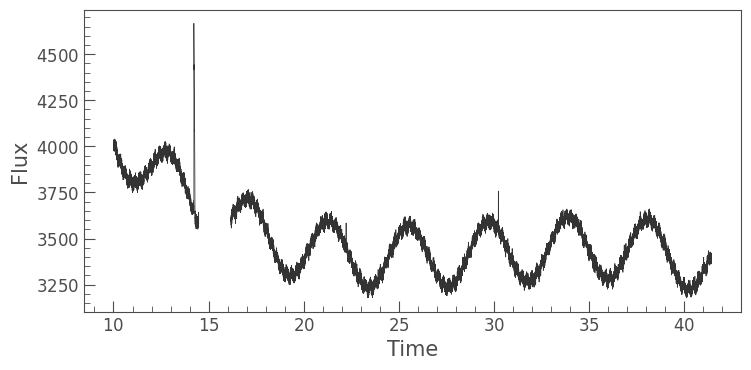

In [183]:
%matplotlib inline

def generate_lightcurve(errorval,  a1, a2,period1, period2, quad, cube,
                        mean=3400.):
    

    time = np.arange(10, 10 + 10 * np.pi,.0008)

    # define the flux
    flux = (np.random.normal(0,errorval,time.shape[0]) +
            mean + 
            a1*mean*np.sin(period1*time +1.)  +
            a2*mean*np.sin(period2*time) +
            quad*(time-25)**2 -
            cube*(time-25)**3)

    # add a gap in the data
    flux[5600:7720] = np.nan

    # add big and long flare
    l = 66
    flux[5280:5280 + l] = flux[5280:5280 + l] + np.linspace(1000,250,l)

    # add tiny flare
    l = 3
    flux[15280:15280 + l] = flux[15280:15280 + l] + np.linspace(100,60,l)

    # add intermediate flare
    l, s = 15, 25280
    flux[s:s + l] = flux[s:s + l] + np.linspace(200,60,l)

    # typically Kepler and TESS underestimate the real noise
    err = np.full_like(time,errorval/3*2)

    # define FLC
    return FlareLightCurve(time=time, flux=flux, flux_err=err)


lc = generate_lightcurve(errorval=15, a1=.05, a2=0.005, period1=1.5, period2=24.4, quad=1.5, cube=0.1)
lc.plot();


In [184]:
cases = [(.05, 0.005, 1.5, 24.4, 1.5, 0.1),
         (.1, 0.005, 1.5, 14.4, 1.5, 0.5),
         (.1, 0.05, 1.5, 8, 1.5, 0.5),
         (.01, .1, 1.5, 8, -.5, 0.25),
         (.3, .05, .5, 30, -.5, 0.25),
         ]

@pytest.mark.parametrize("a1,a2,period1,period2,quad,cube", cases)
def test_is_powerlaw_truncated(a1, a2, period1, period2, quad, cube,):
    
    # fix uncertainty
    errorval = 15.
    np.random.seed(40)
    lc = generate_lightcurve(errorval, a1, a2, period1, period2, quad, cube)

    lc.plot()
    flcc = custom_detrending(lc)

    flccc = estimate_detrended_noise(flcc, mask_pos_outliers_sigma=2.5, 
                                     std_window=100)

    flccc = find_iterative_median(flccc)

    flccc = remove_exp(flccc)

#     flares = flccc.find_flares(addtail=True).flares

#     # check that uncertainty is 
#     assert np.nanmedian(flccc.detrended_flux_err) == pytest.approx(errorval, abs=2)

#     print(flares)
#     compare = pd.DataFrame({'istart': {0: 5280, 1: 13160, 2: 23160},
#                             'istop': {0: 5346, 1: 13163, 2: 23175}})
#     assert (flares[["istart","istop"]] == compare[["istart","istop"]]).all().all()
#     print(flares.ed_rec.values)
#     assert (flares.ed_rec.values ==
#             pytest.approx(np.array([802.25, 4.7907, 40.325]), rel=0.15))

#     assert (flares.ampl_rec.values ==
#             pytest.approx(np.array([0.28757, 0.03004, 0.064365]), rel=0.15))
    return flccc

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

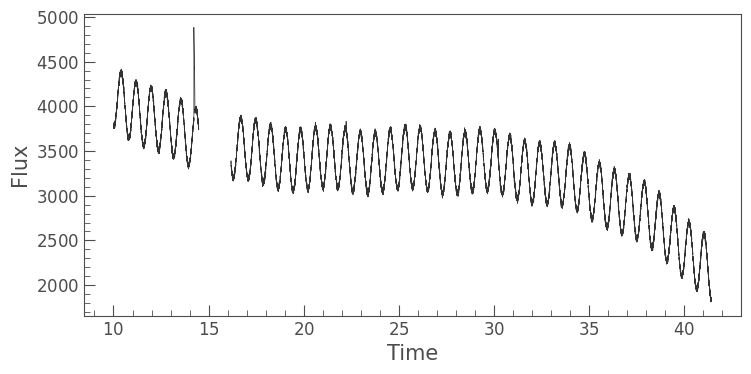

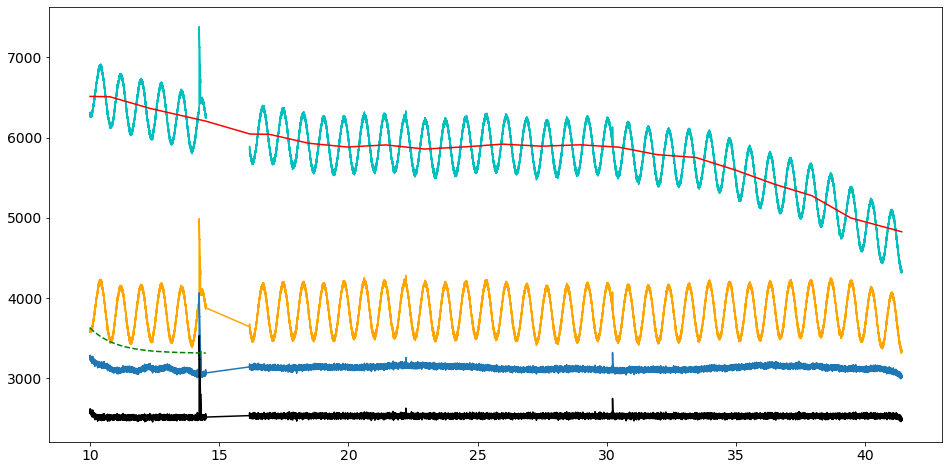

In [189]:
flccc = test_is_powerlaw_truncated(*cases[3])


In [188]:
def remove_exp(flcd):
    """dgd"""
    def twoexps(x, a, b, c, d, e,f,g):
        return a * np.exp(b * (c - x)) + d * np.exp(e * (f - x)) + g

    flct = copy.deepcopy(flcd)
    flct.detrended_flux = np.full_like(flct.flux, np.nan)
    
    for le, ri in flct.find_gaps().gaps:
 
        flc = copy.deepcopy(flct[le:ri])

        median = np.nanmedian(flc.it_med)
        
        def texp(x, a, b, d, e, g):
            return twoexps(x, a, b, flc.time[0], d, e, flc.time[-1], g)
      
        sta, fin = flc.flux[0]-median, flc.flux[-1]-median
        plt.plot(flc.time, texp(flc.time,sta, np.sign(sta),fin,np.sign(fin),median), c="g", linestyle="dashed")
        p, p_cov = optimize.curve_fit(texp, flc.time, flc.flux,
                                          p0=[sta,
                                              np.sign(sta),
                                              fin,
                                              np.sign(fin),
                                              median])
        print(p[0], p[1], p[2], p[3], p[4])
        nflux = np.nanmean(flc.flux) + flc.flux - texp(flc.time, p[0], p[1], p[2], p[3], p[4])

        flcd.detrended_flux[le:ri] = nflux
        
    return flcd

(10.0, 12.0)

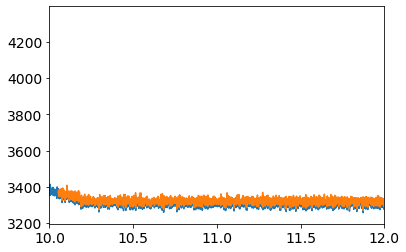

In [163]:
plt.plot(flccc.time,flccc.detrended_flux)
plt.plot(flccc.time,flccc.detrended_flux + flccc.detrended_flux_err)
plt.xlim(10,12)

In [164]:

for le, ri in flccc.gaps:
    flc = flccc[le:ri]
    mask = sigma_clip(flc.detrended_flux)
    std, median = np.std(flc.detrended_flux[mask]), np.median(flc.detrended_flux[mask]) 
    print(std, median)
    i = 0
    outs, out = [], True
    while out == True:
        out = np.abs(flc.detrended_flux[i] - median) > flc.detrended_flux_err[i]
        print(out)
        outs.append(i)
        i+=1
        
    i = -1
    outf, out  = [], True
    while out == True:
        out = np.abs(flc.detrended_flux[i] - median) > flc.detrended_flux_err[i]
        outf.append(i)
        i-=1
        
    print(outs, outf)
#     mask2 = np.where(np.abs(flc.detrended_flux - median) > 3*flc.detrended_flux_err)[0]
#     plt.scatter(flc.time[mask2], flc.detrended_flux[mask2])

15.097414084229948 3307.000090482893
False
[0] [-1]
14.80866741260926 3324.3636803769095
False
[0] [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39, -40, -41, -42]


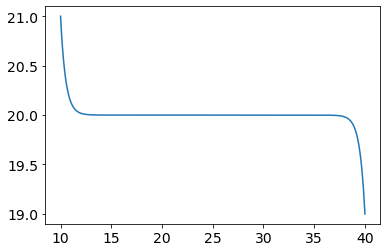

In [165]:
x = np.linspace(10,40,1200)
y1 = -1*np.exp((x-40)*2) + 10
y2 = 1*np.exp((10-x)*2) + 10
plt.plot(x,y1+y2)
flc = FlareLightCurve(time=x, flux=y1+y2, flux_err=np.full_like(y1, .5))

In [166]:
flcd = remove_exp(flc)

0 1200
21.0 19.0
0.9999999999999989 1.999999999999998 -0.9999999999999992 -1.999999999999997 20.0


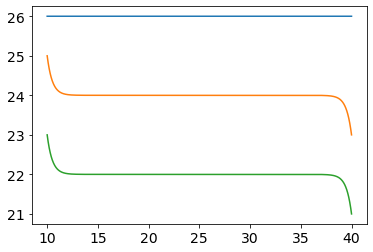

In [169]:
plt.plot(flcd.time, flcd.detrended_flux +6)
plt.plot(flcd.time, flcd.flux +4)

plt.plot(flc.time, flc.flux+ 2)

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(lcs.time, lcs.detrended_flux+200, )
plt.plot(lc.time, lc.flux, c="c")
plt.plot(lc__.time, model, c="r")
plt.plot(flcc.time, flcc.detrended_flux-200, c="yellow")


# plt.xlim(10,15)
plt.ylim(2100,4300);


In [ ]:
plt.figure(figsize=(16,5))

# plt.plot(flc.time, flc.detrended_flux-50, c="k")
plt.plot(flccc.time, flccc.detrended_flux, c="yellow")
plt.plot(flccc.time, flccc.it_med+3*flccc.detrended_flux_err)
plt.plot(flccc.time, flccc.it_med-3*flccc.detrended_flux_err)
plt.plot(flccc.time, flccc.it_med)
# plt.scatter(flc.time[mask], flc.detrended_flux[mask]-400)


# plt.xlim(30,31)
plt.ylim(3300,3800);

In [112]:
df = pd.read_csv("../results/flares.csv")
df.drop_duplicates().dropna(how="any").shape

NumExpr defaulting to 8 threads.


(842, 15)

In [ ]:
(df.tstop-df.tstart).dropna().sort_values(ascending=False).shape

In [ ]:
0.17638323159440006

In [ ]:
2/24/0.01